In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from IPython.display import display, HTML

import warnings
# warnings.filterwarnings('ignore')

# load custom functions
# os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Entity Matching for Online Marketplaces



In [62]:
# Load Data
DATA_DIRECTORY = '//files/share/goods/OI Team'
os.chdir(DATA_DIRECTORY)

train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')

## What is Entity Matching (EM)?

## Why is EM needed for online marketplaces?

In [58]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

# my_file = open('plots/table_1_matched_offer_pairs.html', 'w')
# my_file.write(h.data)
# my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


## Exploratory Data Analysis

### Dataset Origin



Text(0.5, 1.0, 'Top Domains')

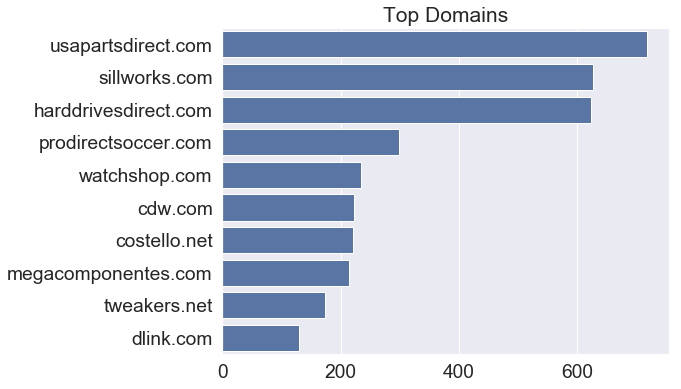

In [49]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Top Domains')

### Offer Features

#### There are 10 offer features that comprise 5 broad feature types.

- 6 are short-to-medium free-text attributes
    - 4 of them are types of indentifiers: gtin, mpm, sku and a generic identifier
    - 2 of them are the brand and manufacturer

- The offer name is the medium-length text attributes
    
- The description is a longer free-text attribute

- The offer category has a limited number of strongly-typed values

- The price is a numeric feature

In [92]:
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['category', 'price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_TEXT_FEATURES + OTHER_FEATURES
                  
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]

display(HTML(train_test_offer_features_only.head(3).to_html(index=False)))

gtin,mpn,sku,identifier,brand,manufacturer,name,description,category,price
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,Computers_and_Accessories,155.94
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,Computers_and_Accessories,155.94
NaN,NaN,NaN,NaN,NaN,hp,hp 16gb ddr3 sdram memory module 16 gb 1 x 16 gb ddr3 sdram 1600 mhz ddr3 1600 pc3 12800 registereddimm,NaN,Computers_and_Accessories,NaN


### Feature Sparsity

In [277]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[feature_nulls.index].isnull().T

<Figure size 576x1440 with 0 Axes>

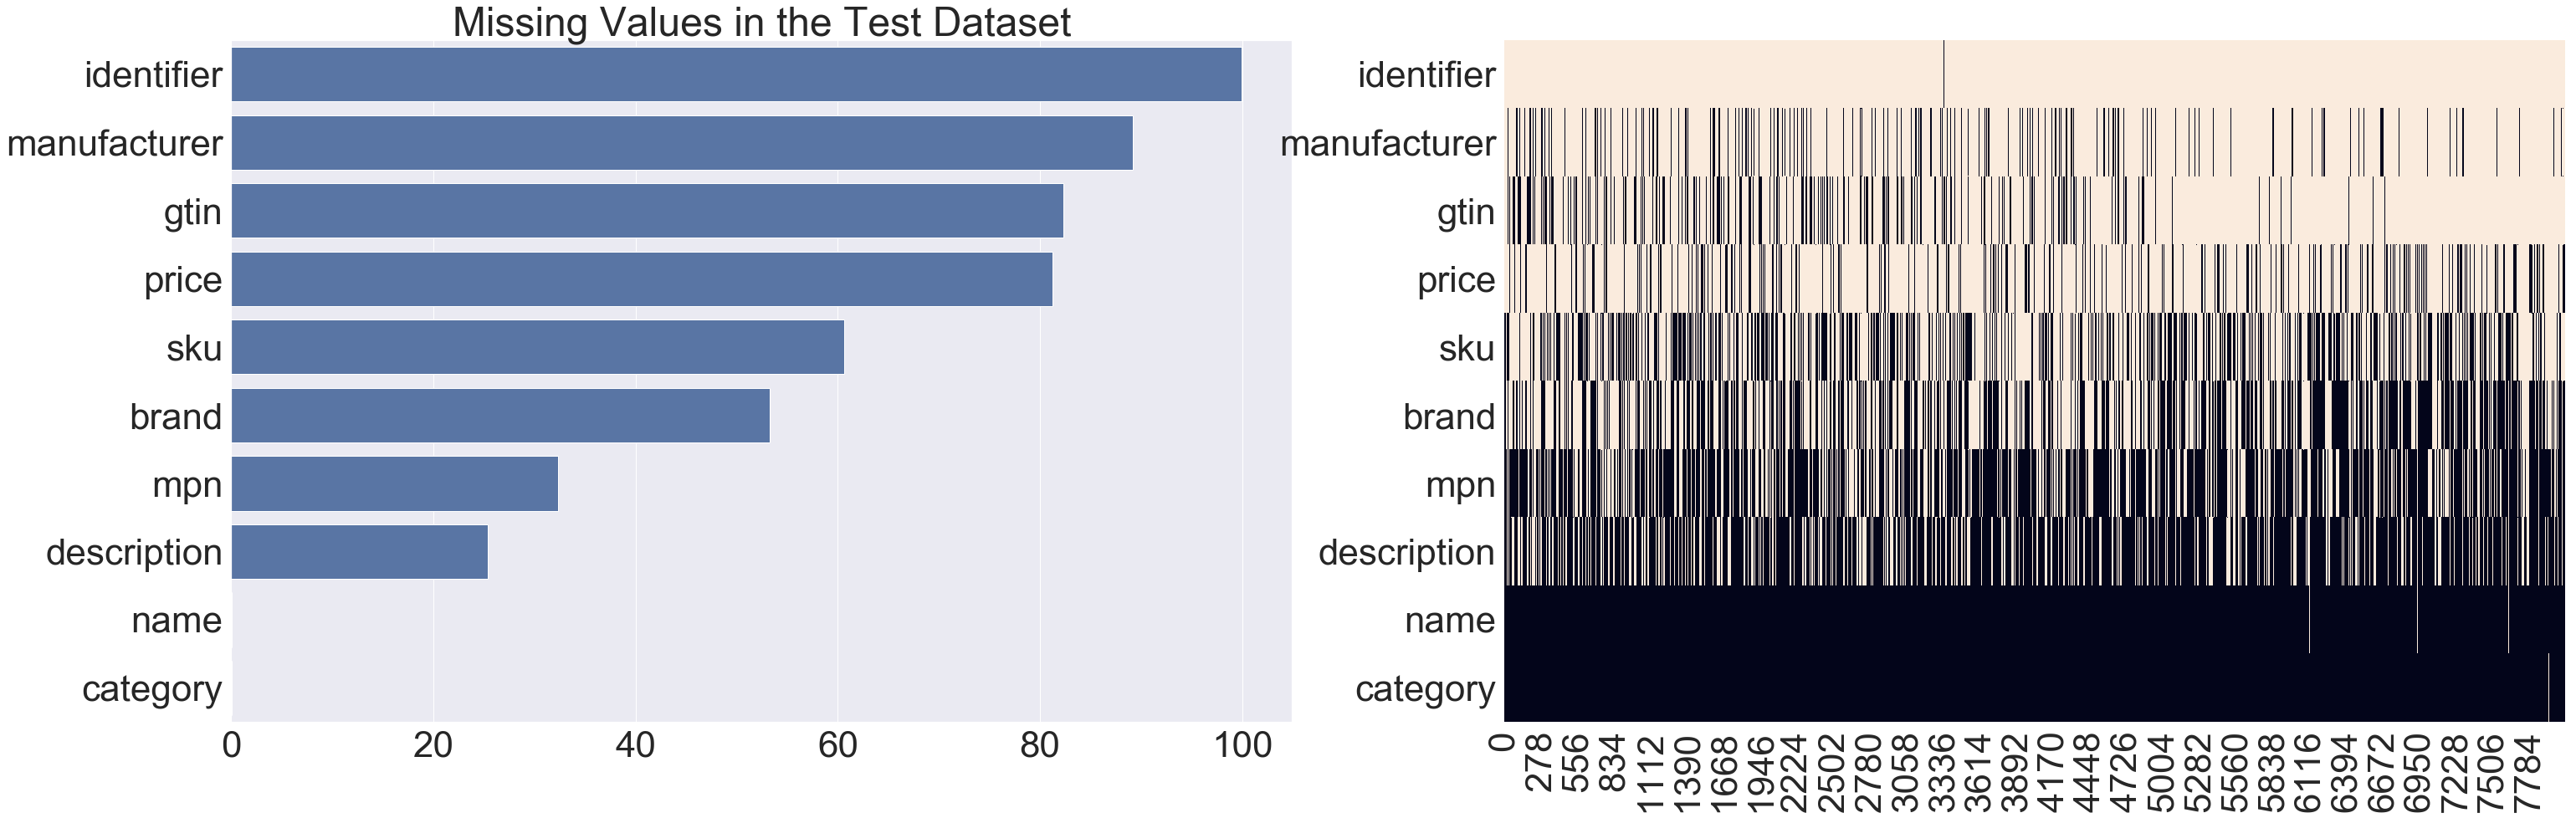

In [278]:
plt.figure(figsize=(8, 20))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))

sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Missing Values in the Test Dataset')

sns.heatmap(nulls_by_index, cbar=False, ax=axes[1])

### Text Lengths



In [107]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

[None]

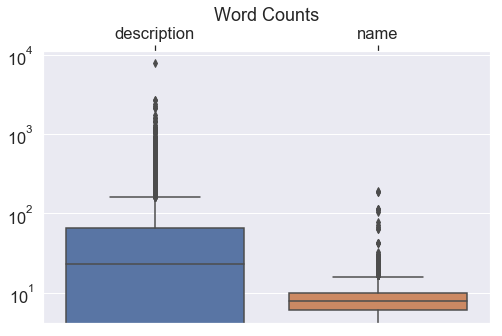

In [123]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Word Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

In [166]:
# count chararters for short-text features
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

[None]

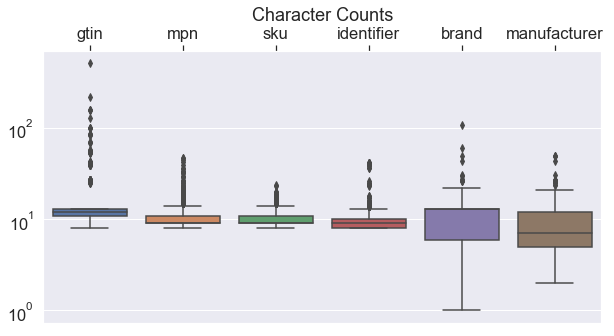

In [165]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Character Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

### Top Values by Attribute

In [223]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

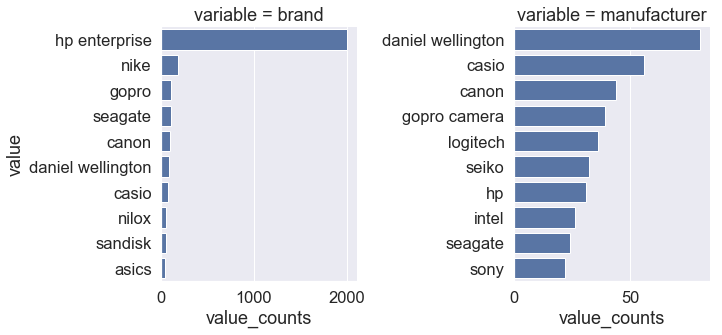

In [260]:
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)

g.map(sns.barplot, 'value_counts', 'value')

### Unique Value Counts

In [256]:
unique_values = train_test_normalized_features[ALL_FEATURES].apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

Text(0.5, 1.0, 'Unique Values')

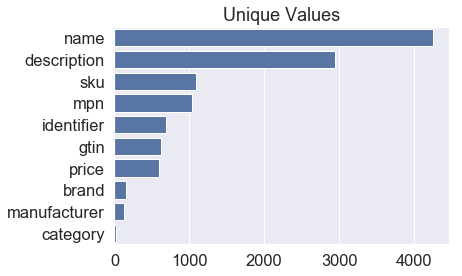

In [259]:
sns.barplot(x = unique_values, y=unique_values.index, 
            color="b")\
            .set_title('Unique Values')

### Training & Testing Data Characteristics

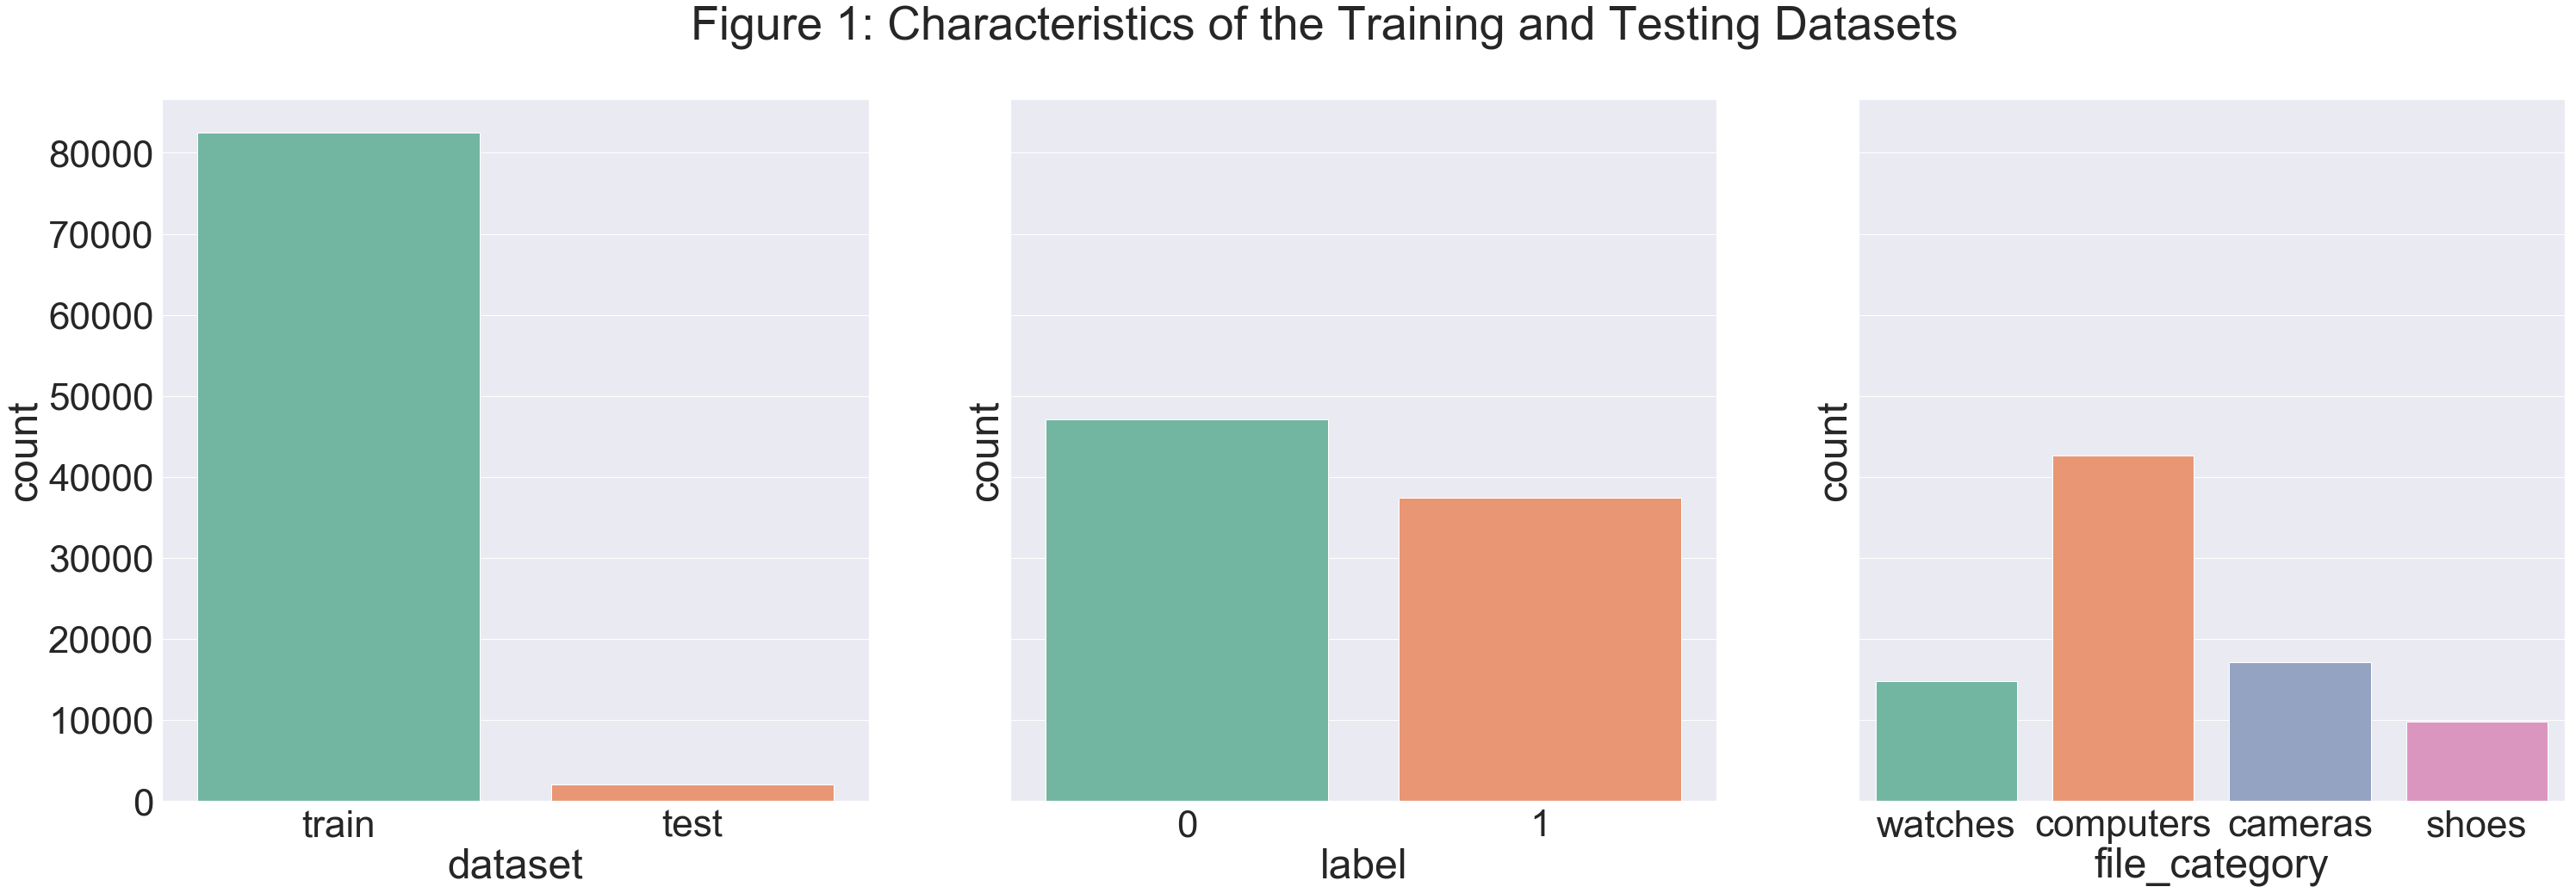

In [66]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(50, 15), sharey=True) 

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Figure 1: Characteristics of the Training and Testing Datasets")

sns.countplot(x='dataset', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

# mosaic plot: https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html
sns.countplot(x='label', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

sns.countplot(x='file_category', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[2])

# plt.savefig('plots/test_train_characteristics.png')

### Testing Data Characteristics


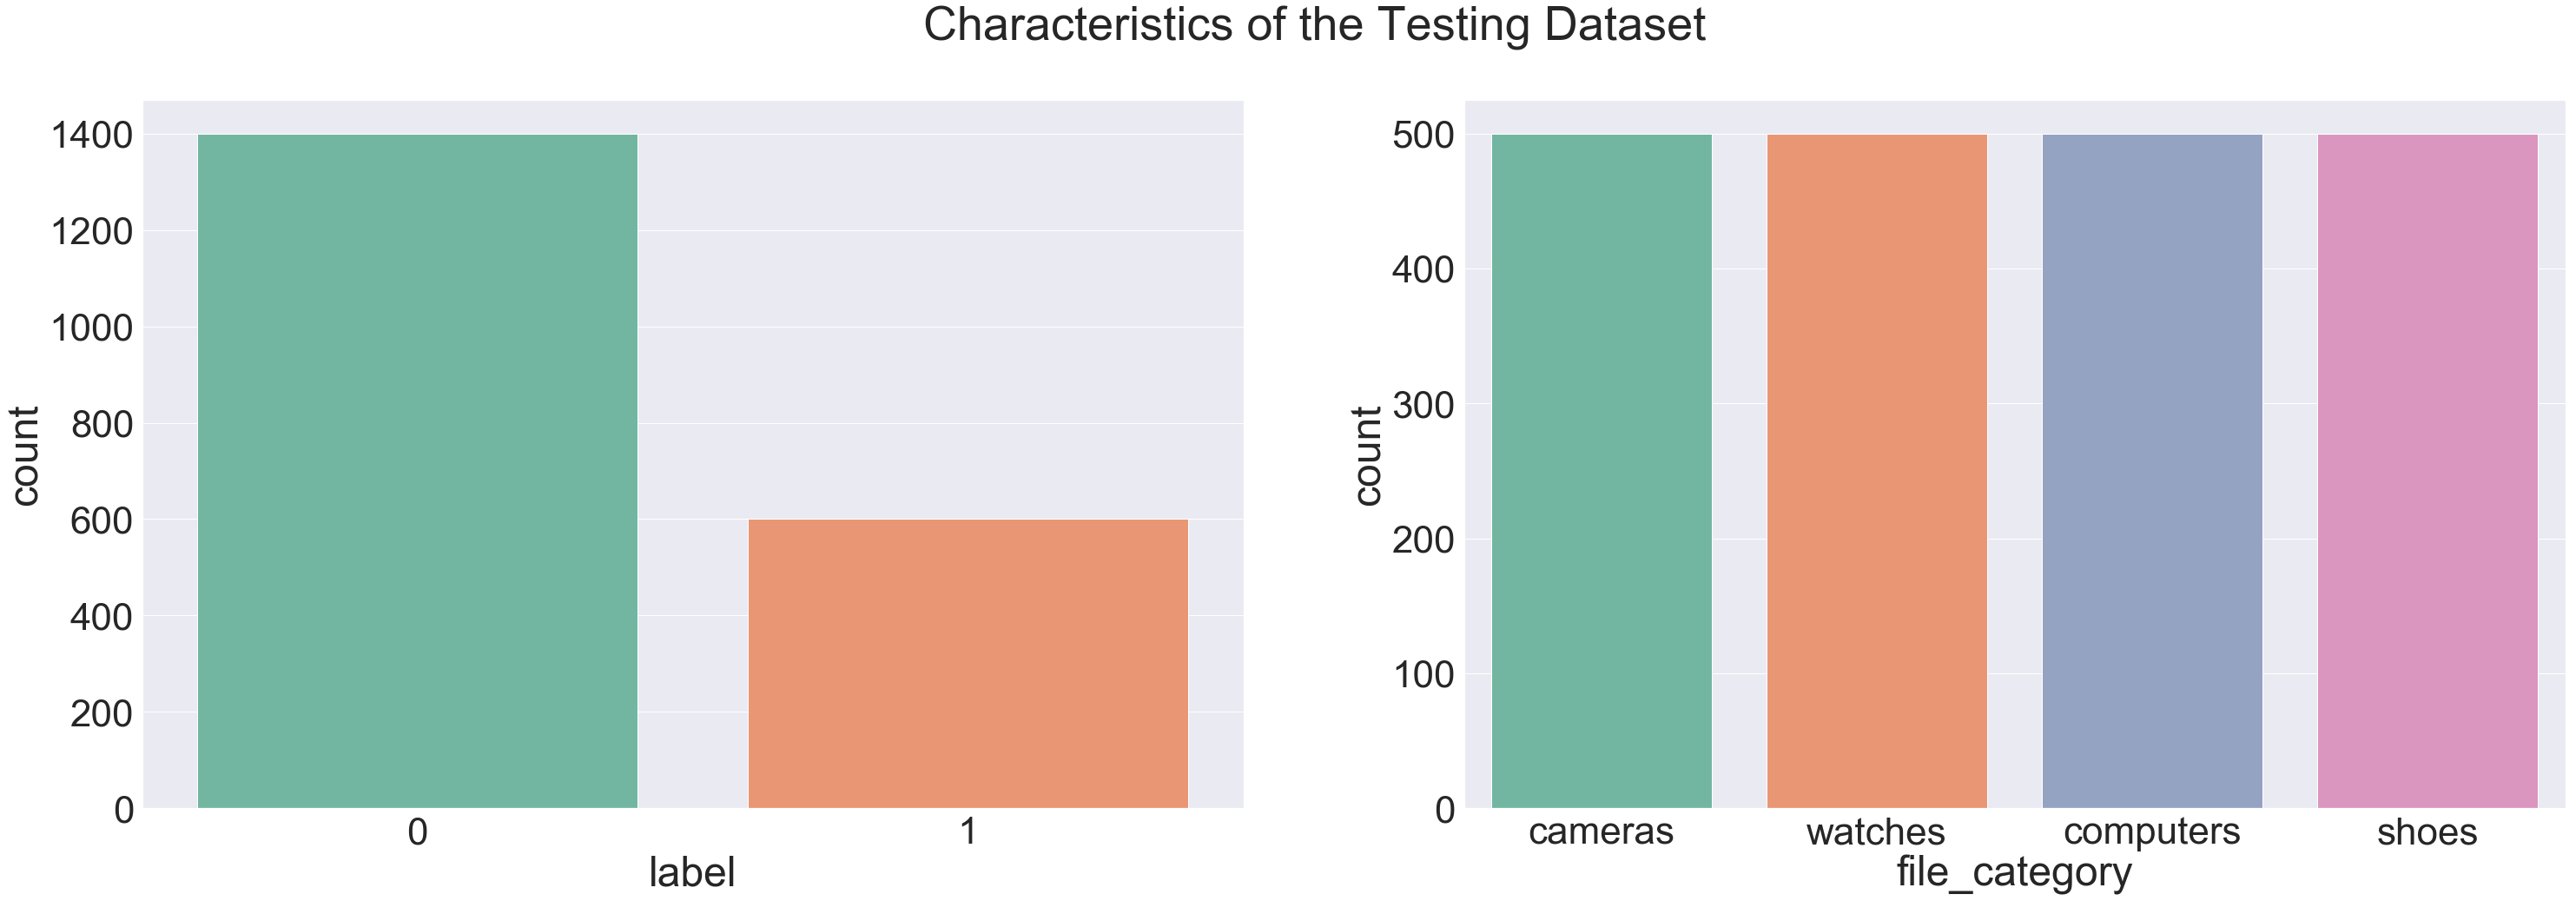

In [68]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) #

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Characteristics of the Testing Dataset")

sns.countplot(x='label', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='file_category', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

plt.savefig('plots/test_characteristics.png')

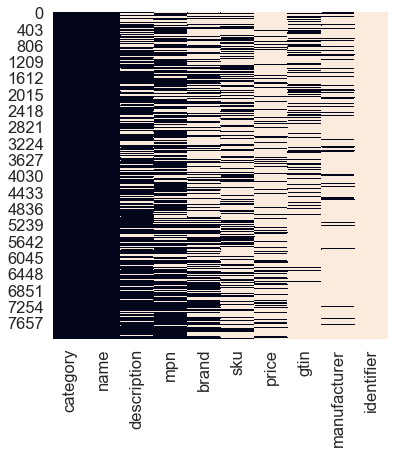

In [268]:
plt.figure(figsize=(6, 6))

# offer_categories = train_test_offer_features.category.value_counts()
# offer_categories_df = pd.DataFrame({'category': offer_categories.index, 'n': offer_categories})

# sns.barplot(x='n', y='category', data=offer_categories_df)

